---
layout: post
title: Learner Notebook
author: FastAI, Jeremy Howard
date: "2020-09-05"
---

In [ ]:
try:
    import fastcore.all
except:
    import sys
    sys.path.append('/Users/mannypardo/DEV/GitHub/course22p2')
    import fastcore.all as fc
    from miniai.conv import *

import math,torch,matplotlib.pyplot as plt
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from fastprogress import progress_bar,master_bar

In [7]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close
import numpy as np

In [8]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
logging.disable(logging.WARNING)

## Learner

In [10]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [11]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [12]:
bs = 512
lr = 0.2
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [13]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([512, 784]), tensor([2, 8, 7, 3, 0, 3, 2, 8, 6, 9]))

## Basic Callbacks Learner

In [14]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [15]:
class Callback(): order = 0

In [16]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

## Metrics

In [17]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps
    

In [18]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

## Some callbacks

```
pip install torcheval
```

In [19]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [20]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [21]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [22]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

## Flexible learner

In [23]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

In [24]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

NB: Added validation loss plotting after the lesson.

In [25]:
bs = 1014
lr = 0.9
m,nh = 28*28,100

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1014, 784]), tensor([8, 8, 5, 0, 6, 2, 5, 1, 8, 4]))

In [26]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [27]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

## TrainLearner and MomentumLearner

In [28]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [29]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.693,0.916,0,train
0.785,0.586,0,eval


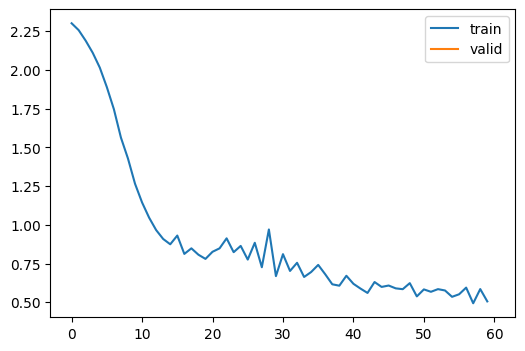

In [30]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [75]:
class CosAnnealCB(Callback):
    def __init__(self, lr_mult=1.3): 
        fc.store_attr()
 
    def before_fit(self, learn):
        self.epochs, self.lrs,self.losses = [],[], []
        self.min = math.inf
        self.t_iter = len(learn.dls.train) * learn.n_epochs

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        c_iter = learn.iter
        self.losses.append(loss)
        self.epochs.append(c_iter)
        if loss < self.min: self.min = loss
        if loss > self.min*2: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
        g['lr'] = g['lr']*max(np.cos((1-4.0*np.pi*(c_iter / self.t_iter))),1.5)
        

In [76]:
lrfind = CosAnnealCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-6, cbs=cbs)
learn.fit(1)


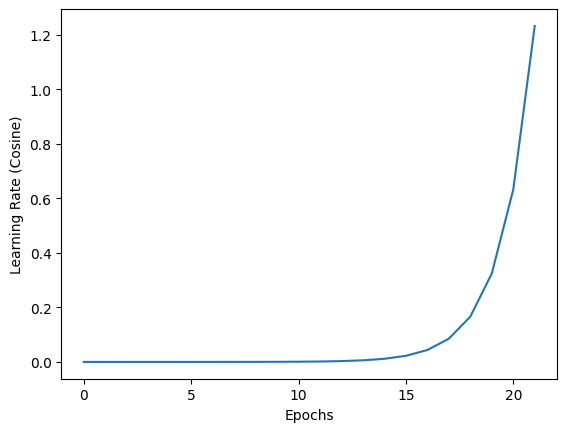

In [77]:
#| label: "cos-epoch-lr"
#| fig-cap: "Fig 3 - Learning Rate Cosine Annealer"
plt.plot(lrfind.epochs, lrfind.lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate (Cosine)')
plt.xscale('linear')

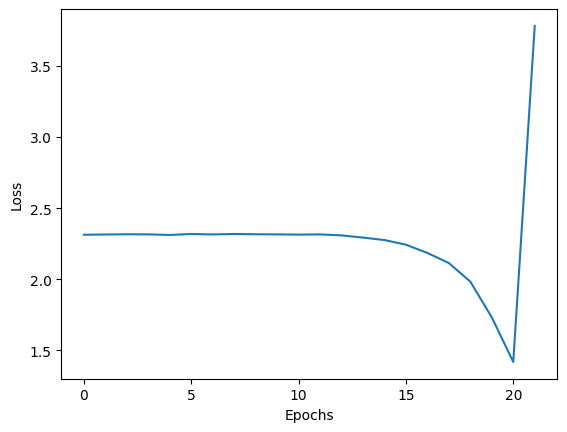

In [78]:
#| label: "cos-loss-epoch"
#| fig-cap: "Fig 4 - Learning Rate Cosine Annealer"
plt.plot(lrfind.epochs, lrfind.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('linear')

In [72]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): 
        fc.store_attr()
 
    def before_fit(self, learn):
        self.epochs, self.lrs,self.losses = [],[], []
        self.min = math.inf
        self.t_iter = len(learn.dls.train) * learn.n_epochs

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        c_iter = learn.iter
        self.losses.append(loss)
        self.epochs.append(c_iter)
        if loss < self.min: self.min = loss
        if loss > self.min*2: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

In [73]:
lrfind = LRFinderCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-6, cbs=cbs)
learn.fit(1)

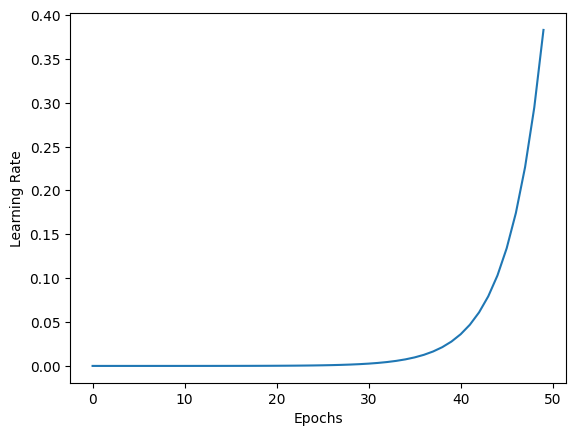

In [74]:
#| label: "epoch-lr"
#| fig-cap: "Fig 1 - Learning Rate Finder"
plt.plot(lrfind.epochs, lrfind.lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.xscale('linear')

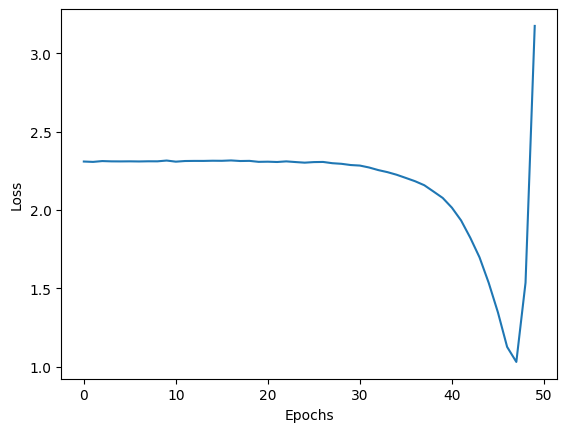

In [51]:
#| label: "loss-epoch"
#| fig-cap: "Fig 2 - Learning Rate Cosine Annealer"
plt.plot(lrfind.epochs, lrfind.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('linear')